In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import numpy as np
import pandas as pd

# Discrete Data + Probability
### Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [2]:
# acquire data

colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [6]:
# parse datetime

# replace mumbo jumno in timestamp column
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

# continue to normalize text them change timestamp to datetime
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

# change timestamp to datetime
df = df.set_index('timestamp')

In [7]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [8]:
# continue cleanup
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [11]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

# drop the size column
df.drop(columns= 'size', inplace = True)

In [12]:
df.describe()

,status,size_mb
count,13978.000000,13978.000000
mean,200.356703,0.429155
std,10.182001,0.154010
min,200.000000,0.000000
25%,200.000000,0.477445
50%,200.000000,0.486506
75%,200.000000,0.487605
max,499.000000,1.961066


In [14]:
df.request_method.nunique()

22

In [15]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/items&page=0 HTTP/1.1                   1
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1
GET /api/v1 HTTP/1.1                                1
GET /api/v1/items/HTTP/1.1  

In [16]:
# get the counts of request methods in the dataset

rm_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'rm_count'})

rm_df

,request_method,rm_count
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229
3,GET / HTTP/1.1,107
4,GET /documentation HTTP/1.1,100
5,GET /favicon.ico HTTP/1.1,26
6,GET /api/v1//api/v1/items HTTP/1.1,11
7,GET /api/v1/items/api/v1/items HTTP/1.1,7
8,GET /api/v1/items/next_page HTTP/1.1,5
9,GET /api/v1/ HTTP/1.1,4


In [17]:
# calculate probabity for each request method

# rm_prob = count for each rm / total count in the dataframe

rm_df2 = pd.DataFrame((df.request_method.value_counts(dropna=False))/df.request_method.count()).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'rm_proba'})
rm_df2

,request_method,rm_proba
0,GET /api/v1/sales HTTP/1.1,0.887323
1,GET /api/v1/items HTTP/1.1,0.076191
2,GET /api/v1/stores HTTP/1.1,0.016383
3,GET / HTTP/1.1,0.007655
4,GET /documentation HTTP/1.1,0.007154
5,GET /favicon.ico HTTP/1.1,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,0.000358
9,GET /api/v1/ HTTP/1.1,0.000286


In [18]:
# merge the two data frames create above into a single one:
rm_df = rm_df.merge(rm_df2)


# look at rows where rm_proba is less than 0.01
rm_df[rm_df.rm_proba < 0.01]

,request_method,rm_count,rm_proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/sales/HTTP/1.1,3,0.000215
11,GET /api/v1/store HTTP/1.1,3,0.000215
12,GET /api/v1/itemsitems HTTP/1.1,3,0.000215


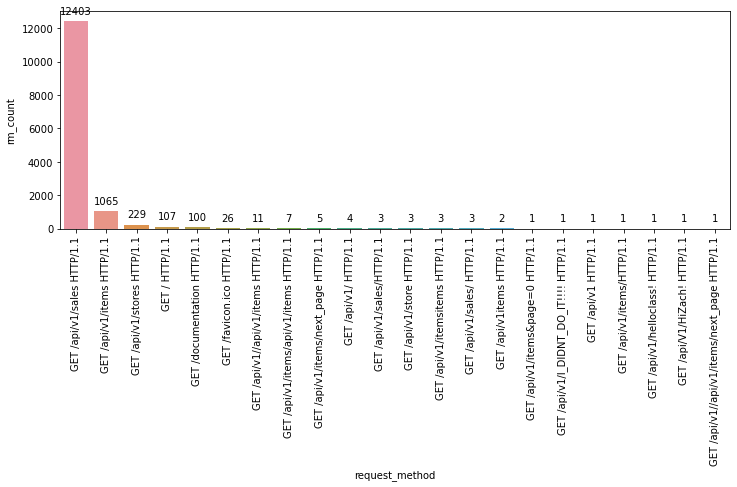

In [21]:
# plot the ip_count for each ip

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=rm_df, x = 'request_method', y = 'rm_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Detecting anomalies by establishing a baseline and evaluate as new data arrives.

##### Establish Baseline:

In [22]:
# #establish baseline 

train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [24]:
# Compute probabilities based on train sample:

rm_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_proba'})

rm_df

,request_method,rm_proba
0,GET /api/v1/sales HTTP/1.1,0.887577
1,GET /api/v1/items HTTP/1.1,0.076213
2,GET /api/v1/stores HTTP/1.1,0.016388
3,GET / HTTP/1.1,0.007657
4,GET /documentation HTTP/1.1,0.007156
5,GET /favicon.ico HTTP/1.1,0.001861
6,GET /api/v1//api/v1/items HTTP/1.1,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,0.000358
9,GET /api/v1/ HTTP/1.1,0.000286


In [25]:
# Merge probabilities with all data (train + new data):

# Where the request method address is new, i.e. not seen in the training 
#  dataset, fill the probability with a value of 0.

df = df.reset_index().merge(rm_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df.tail(5)

,ip,request_method,status,destination,request_agent,size_mb,rm_proba
timestamp,,,,,,,
2019-04-17 12:55:14,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486532,0.887577
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,0,python-requests/2.21.0,1.099591,0.000000
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.000958,0.000000
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.002441,0.000000
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales/HTTP/1.1,200,0,python-requests/2.21.0,1.961066,0.000000


### Conditional Probabilities: Probabilities using 2 discrete variables

##### Probability of Status given request method:

In [29]:
train.groupby('request_method').size().sort_values(ascending=False)

request_method
GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/helloclass! HTTP/1.1                    1
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1
GET /api/v1//api/v1/items/next_page HTTP/1.1        1
GET /api/v1 HTTP/1.1                                1
GET /api/V1/H

In [30]:
Pb = train.groupby('request_method').size().div(len(train))
Pab= train.groupby(['request_method', 'status']).\
                                    size().div(len(train))
Pab.div(Pb, axis=0, level='request_method')

request_method                                status
GET / HTTP/1.1                                200       1.000000
GET /api/V1/HiZach! HTTP/1.1                  200       1.000000
GET /api/v1 HTTP/1.1                          200       1.000000
GET /api/v1/ HTTP/1.1                         200       1.000000
GET /api/v1//api/v1/items HTTP/1.1            200       1.000000
GET /api/v1//api/v1/items/next_page HTTP/1.1  200       1.000000
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1        200       1.000000
GET /api/v1/helloclass! HTTP/1.1              200       1.000000
GET /api/v1/items HTTP/1.1                    200       0.996244
                                              499       0.003756
GET /api/v1/items&page=0 HTTP/1.1             200       1.000000
GET /api/v1/items/api/v1/items HTTP/1.1       200       1.000000
GET /api/v1/items/next_page HTTP/1.1          200       1.000000
GET /api/v1/itemsitems HTTP/1.1               200       1.000000
GET /api/v1/sales HTTP/1.1           

In [31]:
# calculate prob for each request_method in train 

rm_probs = train.groupby('request_method').size().div(len(train))

rm_probs

request_method
GET / HTTP/1.1                                  0.007657
GET /api/V1/HiZach! HTTP/1.1                    0.000072
GET /api/v1 HTTP/1.1                            0.000072
GET /api/v1/ HTTP/1.1                           0.000286
GET /api/v1//api/v1/items HTTP/1.1              0.000787
GET /api/v1//api/v1/items/next_page HTTP/1.1    0.000072
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1          0.000072
GET /api/v1/helloclass! HTTP/1.1                0.000072
GET /api/v1/items HTTP/1.1                      0.076213
GET /api/v1/items&page=0 HTTP/1.1               0.000072
GET /api/v1/items/api/v1/items HTTP/1.1         0.000501
GET /api/v1/items/next_page HTTP/1.1            0.000358
GET /api/v1/itemsitems HTTP/1.1                 0.000215
GET /api/v1/sales HTTP/1.1                      0.887577
GET /api/v1/sales/ HTTP/1.1                     0.000215
GET /api/v1/store HTTP/1.1                      0.000215
GET /api/v1/stores HTTP/1.1                     0.016388
GET /api/v1items

In [33]:
# repeat, do the same thing as above, in a different way
# Conditional probability. Given an request method, what is prob of a particular status

status_given_rm = pd.DataFrame(train.groupby(['request_method', 'status']).\
                               size().div(len(train)).\
                               div(rm_probs, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(columns={0: 'proba_status_given_rm'})
                              )

status_given_rm

,request_method,status,proba_status_given_rm
0,GET / HTTP/1.1,200,1.000000
1,GET /api/V1/HiZach! HTTP/1.1,200,1.000000
2,GET /api/v1 HTTP/1.1,200,1.000000
3,GET /api/v1/ HTTP/1.1,200,1.000000
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.000000
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1.000000
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1.000000
7,GET /api/v1/helloclass! HTTP/1.1,200,1.000000
8,GET /api/v1/items HTTP/1.1,200,0.996244
9,GET /api/v1/items HTTP/1.1,499,0.003756


In [34]:
train.groupby(['request_method', 'status'])['ip'].count()

request_method                                status
GET / HTTP/1.1                                200         107
GET /api/V1/HiZach! HTTP/1.1                  200           1
GET /api/v1 HTTP/1.1                          200           1
GET /api/v1/ HTTP/1.1                         200           4
GET /api/v1//api/v1/items HTTP/1.1            200          11
GET /api/v1//api/v1/items/next_page HTTP/1.1  200           1
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1        200           1
GET /api/v1/helloclass! HTTP/1.1              200           1
GET /api/v1/items HTTP/1.1                    200        1061
                                              499           4
GET /api/v1/items&page=0 HTTP/1.1             200           1
GET /api/v1/items/api/v1/items HTTP/1.1       200           7
GET /api/v1/items/next_page HTTP/1.1          200           5
GET /api/v1/itemsitems HTTP/1.1               200           3
GET /api/v1/sales HTTP/1.1                    200       12391
                 

In [36]:
# calculate count for each combination of request method and status
rm_status_count = pd.DataFrame(train.groupby(['request_method', 'status'])['ip'].\
                              count().reset_index().\
                              rename(columns={'ip': 'rm_status_count'}))

# merge rm_status_count with status_given_rm dataframe

rm_status = status_given_rm.merge(rm_status_count)
rm_status

,request_method,status,proba_status_given_rm,rm_status_count
0,GET / HTTP/1.1,200,1.000000,107
1,GET /api/V1/HiZach! HTTP/1.1,200,1.000000,1
2,GET /api/v1 HTTP/1.1,200,1.000000,1
3,GET /api/v1/ HTTP/1.1,200,1.000000,4
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.000000,11
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1.000000,1
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1.000000,1
7,GET /api/v1/helloclass! HTTP/1.1,200,1.000000,1
8,GET /api/v1/items HTTP/1.1,200,0.996244,1061
9,GET /api/v1/items HTTP/1.1,499,0.003756,4


In [37]:
# add these probabilities to original events to detect anomalous events:
df = df.reset_index().merge(rm_status, on=['request_method', 'status'], how='left').fillna(value=0).set_index('timestamp')

df.head(3)

,ip,request_method,status,destination,request_agent,size_mb,rm_proba,proba_status_given_rm,rm_status_count
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488753,0.887577,0.999032,12391.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486472,0.887577,0.999032,12391.0


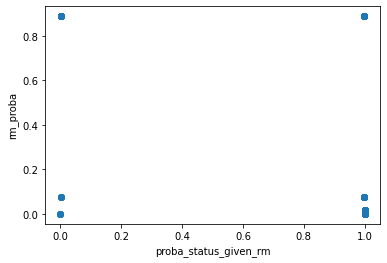

In [38]:
# plot the probabilities

plt.scatter(df.proba_status_given_rm, df.rm_proba)
plt.xlabel('proba_status_given_rm')
plt.ylabel('rm_proba');

In [39]:
df[(df['proba_status_given_rm'] < 0.2) & (df['rm_proba'] < 0.2)]

,ip,request_method,status,destination,request_agent,size_mb,rm_proba,proba_status_given_rm,rm_status_count
timestamp,,,,,,,,,
2019-04-16 20:38:13,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.076213,0.003756,4.0
2019-04-16 20:38:55,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.076213,0.003756,4.0
2019-04-16 20:39:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.076213,0.003756,4.0
2019-04-16 20:45:17,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.076213,0.003756,4.0
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,0,python-requests/2.21.0,1.099591,0.000000,0.000000,0.0
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.000958,0.000000,0.000000,0.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.002441,0.000000,0.000000,0.0
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales/HTTP/1.1,200,0,python-requests/2.21.0,1.961066,0.000000,0.000000,0.0


In [40]:
df[(df['proba_status_given_rm'] < 0.8) & (df['rm_proba'] < 0.8)]

,ip,request_method,status,destination,request_agent,size_mb,rm_proba,proba_status_given_rm,rm_status_count
timestamp,,,,,,,,,
2019-04-16 20:38:13,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.076213,0.003756,4.0
2019-04-16 20:38:55,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.076213,0.003756,4.0
2019-04-16 20:39:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.076213,0.003756,4.0
2019-04-16 20:45:17,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.076213,0.003756,4.0
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,0,python-requests/2.21.0,1.099591,0.000000,0.000000,0.0
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.000958,0.000000,0.000000,0.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.002441,0.000000,0.000000,0.0
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales/HTTP/1.1,200,0,python-requests/2.21.0,1.961066,0.000000,0.000000,0.0
